In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from sdebridge import diffusion_bridge as db
from sdebridge import sdes
from sdebridge.utils import score_fn, fourier_coefficients, inverse_fourier
from sdebridge.data_processing import sample_ellipse, butterfly2_pts

import matplotlib.pyplot as plt
import jax
import jax.numpy as jnp

In [3]:
T=1.
N=50
dim=2
num_bases = 8
alpha = 1.0
sigma = 0.1
n_grid = 64
grid_range = (-1.5, 1.5)
n_samples = 100

sde = sdes.fourier_gaussian_kernel_sde(T, N, dim, num_bases, alpha, sigma, n_grid, grid_range, n_samples)

In [4]:
initial_butterfly = jnp.load('../data/tom_pts.npy')
target_butterfly = jnp.load('../data/honrathi_pts.npy')
print("initial_butterfly.shape", initial_butterfly.shape)
print("target_butterfly.shape", target_butterfly.shape)

initial_coeffs = fourier_coefficients(initial_butterfly, num_bases)
target_coeffs = fourier_coefficients(target_butterfly, num_bases)

initial_butterfly.shape (120, 2)
target_butterfly.shape (120, 2)


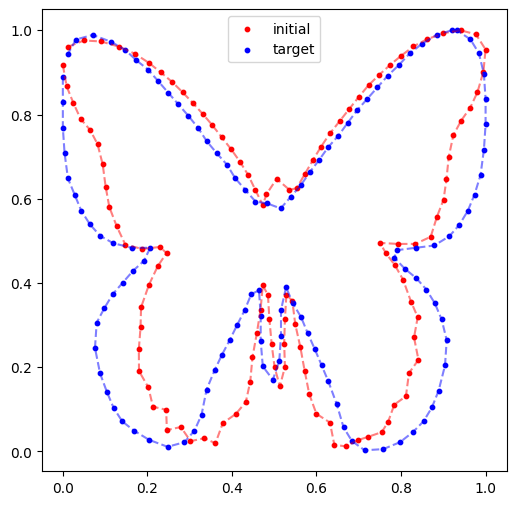

In [5]:
def plot_butterfly_pts(pts, ax, color='r', label=None):
    ax.scatter(pts[:, 0], pts[:, 1], color=color, label=label, s=10)
    ax.plot(pts[:, 0], pts[:, 1], color=color, alpha=0.5, linestyle='--')
    return ax

fig, ax = plt.subplots(1, 1, figsize=(6, 6))
ax = plot_butterfly_pts(initial_butterfly, ax, color='r', label='initial')
ax = plot_butterfly_pts(target_butterfly, ax, color='b', label='target')
ax.legend()
plt.show()

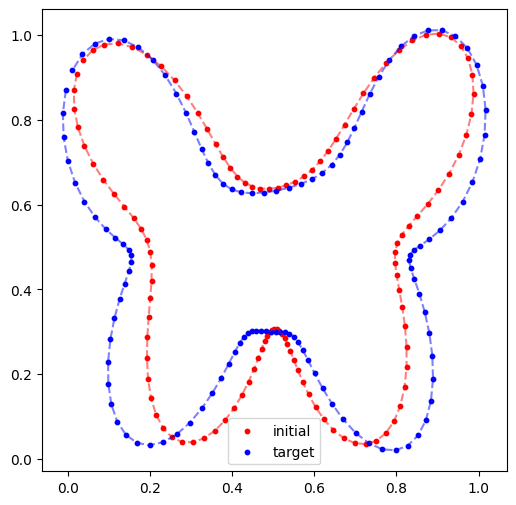

In [6]:
# plot butterflies reconstructed from coeffs

initial_plt = inverse_fourier(initial_coeffs, 120)
target_plt = inverse_fourier(target_coeffs, 120)

fig, ax = plt.subplots(1, 1, figsize=(6, 6))
ax = plot_butterfly_pts(initial_plt, ax, color='r', label='initial')
ax = plot_butterfly_pts(target_plt, ax, color='b', label='target')
ax.legend()
plt.show()

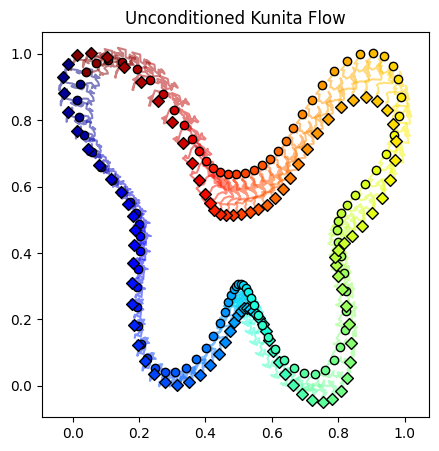

In [7]:
from sdebridge.plotting import plot_single_trajectory

key = jax.random.PRNGKey(2)
forward_trajs = sdes.simulate_traj(sde, initial_coeffs, 64, key)
forward_traj_coeffs = forward_trajs[0]
forward_traj = inverse_fourier(forward_traj_coeffs, 100)
traj = forward_traj.reshape((N, -1))
plot_single_trajectory(traj, "Unconditioned Kunita Flow")

In [8]:
from sdebridge.networks.score_unet import ScoreUNet

net = ScoreUNet

network = {
    "output_dim": sde.dim*sde.n_bases,
    "time_embedding_dim": 32,
    "init_embedding_dim": 32,
    "act_fn": "silu",
    "encoder_layer_dims": [64, 32, 16, 8],
    "decoder_layer_dims": [8, 16, 32, 64],
    "batchnorm": True,
}
    
training = {
    "batch_size": 64,
    "load_size": 512,
    "num_epochs": 100,
    "learning_rate": 1e-3,
    "warmup_steps": 0,
}

target = target_coeffs

train_key = jax.random.split(key, 2)[0]
score_p_state = db.learn_p_score(sde, target, train_key, **training, net=net, network_params=network)

Training: 100%|██████████| 100/100 [55:12<00:00, 33.12s/epoch, Epoch=100, loss=11.6287] 


In [9]:
reverse_sde = sdes.reverse(sde, score_fn(score_p_state))
backward_coeffs = sdes.simulate_traj(reverse_sde, initial_coeffs, 2, key)
forward_coeffs = sdes.simulate_traj(sde, initial_coeffs, 2, key)

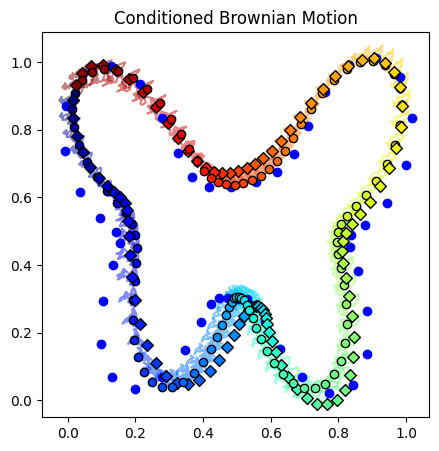

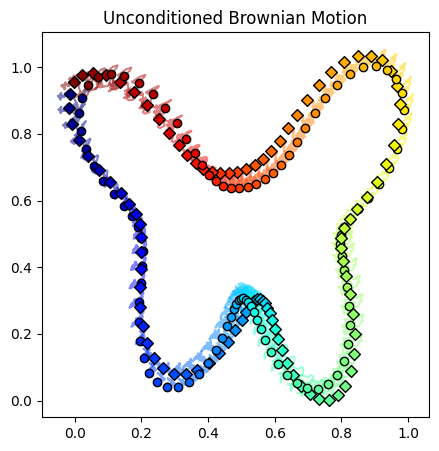

In [10]:
backward_traj = inverse_fourier(backward_coeffs[1], 100)
traj = backward_traj.reshape((N, -1))
plot_single_trajectory(traj, "Conditioned Brownian Motion")
target_plt = inverse_fourier(target, 50)
plt.scatter(target_plt[:, 0], target_plt[:, 1], c="b")

forward_traj = inverse_fourier(forward_coeffs[1], 100)
traj = forward_traj.reshape((N, -1))
plot_single_trajectory(traj, "Unconditioned Brownian Motion")

(2, 50, 16, 2)


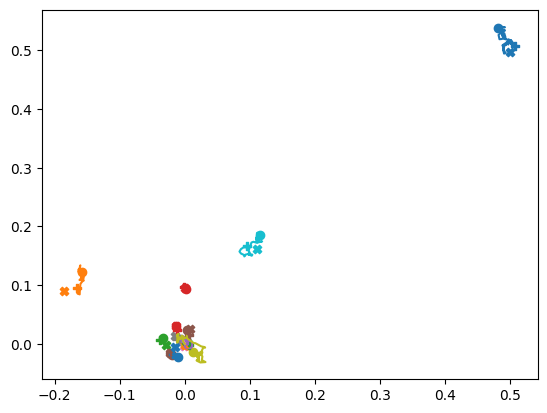

In [11]:
plt_backward_coeffs = backward_coeffs[0]
print(backward_coeffs.shape)

for i, coeff in enumerate(range(2*num_bases)):
    plt.scatter(plt_backward_coeffs[-1, coeff, 0], plt_backward_coeffs[-1, coeff, 1], color=f"C{i}")
    plt.scatter(plt_backward_coeffs[0, coeff, 0], plt_backward_coeffs[0, coeff, 1], color=f"C{i}", marker="P")

    plt.plot(plt_backward_coeffs[:, coeff, 0], plt_backward_coeffs[:, coeff, 1], color=f"C{i}")
    plt.scatter(target[coeff, 0], target[coeff, 1], color=f"C{i}", marker="X")